# Social Vulnerability Logroño - Calculate Vulnerability

## Environment

### R Libraries
The relvant R libraries are imported in to the kernal:

In [1]:
# Load R libraries
if(!require("pacman"))
    install.packages("pacman")

p_load("sf", "tidyverse")

print("Loaded Packages:")
p_loaded()

Loading required package: pacman



[1] "Loaded Packages:"


[1] "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"     "readr"    
 [7] "tidyr"     "tibble"    "ggplot2"   "tidyverse" "sf"        "pacman"

### Output directory

In [2]:
# create the output directory if it does not exist
output_dir <- file.path("../..","3_outputs","Spain","Logrono","2021")
if(!dir.exists(output_dir)){
    dir.create(output_dir, recursive = TRUE)
    print(paste0(output_dir, " created"))
}

### Set the GUID

In [3]:
GUID <- c("CCA", "CPRO", "CMUN", "CDIS", "CSEC")
GUID_census_indicator_data <- c("ccaa", "CPRO", "CMUN", "dist", "secc")
GUID_length = 5

## Load Data

### Import the data

In [4]:
# Load census data
census_indicator_data <- read.csv("../../2_pipeline/Spain/Logrono/1a_CensusData/2021/censusDataZ.csv")
# Update the census indicator data ID to the common GUID
colnames(census_indicator_data)[colnames(census_indicator_data) %in% GUID_census_indicator_data] = GUID
# Change all the GUID column data type to integer, this helps to merge datasets later in the code
census_indicator_data[GUID] <- lapply(census_indicator_data[GUID], as.integer)
# Print head of census indicator data
head(census_indicator_data)

# Load Coperncius data: tree cover density (TCD) and imperviousness density (IMP)
# Both these datasets already uses the GUID
# Both these datasets contain the census area geometry, so we extract from one of the datasets for use later in the code
tcd_indicator_data <- st_read("../../2_pipeline/Spain/1b_Copernicus/2021/census_areas_TCD.geojson")
imd_indicator_data <- st_read("../../2_pipeline/Spain/1b_Copernicus/2021/census_areas_IMD.geojson")
# Get the geospatial data from the TCD data (the IMD data also has same spatial data)
oa <- subset(tcd_indicator_data, select = c(GUID, 'geometry'))
# Remove the geospatial geometry from the TCS and IMD datasets
tcd_indicator_data <- st_drop_geometry(tcd_indicator_data)
imd_indicator_data <- st_drop_geometry(imd_indicator_data)
# Change all the GUID column data type to integer, this helps to merge datasets later in the code
imd_indicator_data[GUID] <- lapply(imd_indicator_data[GUID], as.integer)
tcd_indicator_data[GUID] <- lapply(tcd_indicator_data[GUID], as.integer)
oa[GUID] <- lapply(st_drop_geometry(oa[GUID]), as.integer)

# Load vulnerability mapping information from the config file
## This mapping information is used to help guide the amalgamation of the data.
## Weighting can be changed in this file, depending on the scenario.
## Scenario 1 (best case scenario): Weighting values 1 or -1:
##  where 1 means no change
##  or -1 means all the indicator values are multiplied by -1, resulting in an inverse indicator.
## Scenario 2: Weighting values 0.5 or -0.5:
##  For domains with just a single indicators or where there is a lack of information related to missing indicators. 
##  For these domains the weights are halved using a weight of 0.5, or -0.5 for an inverse indicator.
##  Therefore the influence of these indicators are reduced in half.
## Other scenarios are supported by using other decimal numbers if decided for a particular dataset.
indicator_mapping <- read.csv("config/vulnerabilityIndicatorMappings.csv", header=TRUE, sep=",", stringsAsFactors = FALSE, fileEncoding="UTF-8-BOM")

# Print up to 100 rows of vulnerabiltiy mapping config file
head(indicator_mapping,100)

CCA CPRO CMUN CDIS CSEC early_childhood_boy early_childhood_girl
1 17  26   1    1    1    -0.19258164         -0.1467916          
2 17  26   2    1    1     0.23745377          0.3146154          
3 17  26   3    1    1    -0.96122760         -0.1140934          
4 17  26   4    1    1     0.01083739         -1.4002199          
5 17  26   5    1    1    -0.10396496          0.1640514          
6 17  26   5    2    1     2.13595981          1.4136596          
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female disability
1  0.4818082                    -0.10021618                      1.2753218
2 -0.2611307                    -0.31519260                      0.3880289
3  0.3255496                     0.83585043                     -0.4992639
4  0.5976241                    -1.28188374                     -1.3865567
5 -0.1893316                     0.06098884                      1.2753218
6 -0.7006675                    -0.72507994                      0.3880289
  one_parent_households dependants unemployment attending_university
1 -1.459709836          -0.0938240 -1.00214549   1.2303104          
2 -0.007254482           0.1987363  0.87022439   0.2231589          
3 -1.459709836          -0.0938240 -0.37802220   0.7267347          
4           NA          -1.5566254 -1.62626879  -1.2875683          
5 -0.118741371           0.3450164  1.18228604  -0.2804168          
6  1.157623344           1.5152575 -0.06596055   0.2231589          
  no_higher_education foreign_nationals rented     primary_school_age
1  0.07143877          0.1446865        -0.5073936  0.30936208       
2  0.27339067          0.7793089        -0.5005024  0.16550926       
3  0.20607337          0.3985355        -1.0793008  0.26195604       
4  1.61973671         -1.2514828                NA -1.57053273       
5  0.27339067          0.6523844        -0.6041755  0.05555571       
6 -0.06319583          0.1446865        -0.3682738  1.19901504       
  one_person_households year_built 
1  1.0319635            -0.94812767
2  0.4903007             0.24638629
3  0.7214991             2.13797352
4         NA                     NA
5 -0.1104731            -0.08916627
6 -0.4718037            -0.42805727

Reading layer `census_areas_TCD' from data source 
  `/Cities/2_pipeline/Spain/1b_Copernicus/2021/census_areas_TCD.geojson' 
  using driver `GeoJSON'
Simple feature collection with 36333 features and 22 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -1004502 ymin: 3132130 xmax: 1126932 ymax: 4859240
Projected CRS: ETRS89 / UTM zone 30N
Reading layer `census_areas_IMD' from data source 
  `/Cities/2_pipeline/Spain/1b_Copernicus/2021/census_areas_IMD.geojson' 
  using driver `GeoJSON'
Simple feature collection with 36333 features and 22 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -1004502 ymin: 3132130 xmax: 1126932 ymax: 4859240
Projected CRS: ETRS89 / UTM zone 30N


domain                  indicator                       sensitivity prepare
1  age                     early_childhood_boy             1           0      
2  age                     early_childhood_girl            1           0      
3  age                     age_middle_to_oldest_old_male   1           0      
4  age                     age_middle_to_oldest_old_female 1           0      
5  health                  disability                      1           0      
6  income                  one_parent_households           0           1      
7  income                  dependants                      0           1      
8  income                  unemployment                    0           1      
9  income                  attending_university            0           1      
10 info_access_use         no_higher_education             0           1      
11 local_knowledge         foreign_nationals               0           1      
12 tenure                  rented                          0           1      
13 social_network          primary_school_age              0           0      
14 social_network          one_person_households           0           0      
15 housing_characteristics year_built                      0           0      
16 physical_environment    impervious                      0           0      
17 physical_environment    tree_cover_density              0           0      
   respond recover adaptive_capacity enhanced_exposure weight
1  0       0       0                 0                  1    
2  0       0       0                 0                  1    
3  0       0       0                 0                  1    
4  0       0       0                 0                  1    
5  0       0       0                 0                  1    
6  1       1       1                 0                  1    
7  1       1       1                 0                  1    
8  1       1       1                 0                  1    
9  1       1       1                 0                  1    
10 1       1       1                 0                  1    
11 1       0       1                 0                  1    
12 0       0       1                 0                  1    
13 1       1       1                 0                 -1    
14 1       1       1                 0                  1    
15 0       0       0                 1                  1    
16 0       0       0                 1                  1    
17 0       0       0                 1                  1

## Prepare Data

### Combine data into a single indicator dataset

In [5]:
# combine census data with copernicus TCD and IMD data (without geospatial data to avoid duplication)
indicator_data <- merge(census_indicator_data, tcd_indicator_data, by=GUID, all.x=TRUE)
indicator_data <- merge(indicator_data, imd_indicator_data, by=GUID, all.x=TRUE)

# trim the columns
indicator_data <- subset(indicator_data, select=c(names(census_indicator_data), 'tree_cover_density', 'impervious'))

# Set missing data fields to zero (0)
indicator_data[is.na(indicator_data)] <- 0

# Print the first part of the indicators, which are now collated into one table
head(indicator_data)

CCA CPRO CMUN CDIS CSEC early_childhood_boy early_childhood_girl
1 17  26     1  1    1    -0.19258164         -0.1467916          
2 17  26    10  1    1    -0.36188692         -0.3284478          
3 17  26   100  1    1     0.01083739         -1.4002199          
4 17  26   101  1    1    -1.36078806         -1.4002199          
5 17  26   102  1    1     0.10257030         -0.4581527          
6 17  26   102  1    2     0.64987009          0.6302157          
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female disability ⋯
1  0.48180824                   -0.10021618                      1.2753218 ⋯
2  1.32081073                    0.44848018                     -1.3865567 ⋯
3  0.23798535                   -0.52201032                     -1.3865567 ⋯
4 -0.22155305                    0.07955613                     -1.3865567 ⋯
5  0.05129390                    0.59299501                      0.3880289 ⋯
6 -0.04065368                    0.64469364                      0.3880289 ⋯
  unemployment attending_university no_higher_education foreign_nationals
1 -1.0021455    1.2303104           0.071438769          0.1446865       
2 -1.6262688   -1.2875683           1.619736710         -1.2514828       
3 -1.6262688   -1.2875683           1.619736710         -1.2514828       
4 -1.6262688   -1.2875683           1.619736710         -1.2514828       
5  1.0262552    0.2231589           0.138756071         -0.1091625       
6  0.7141936   -0.7839926           0.004121467          0.1446865       
  rented     primary_school_age one_person_households year_built
1 -0.5073936  0.3093621         1.0319635             -0.9481277
2  0.0000000 -0.6060650         0.0000000              0.0000000
3  0.0000000 -0.9083608         0.0000000              0.0000000
4  0.0000000 -1.5705327         0.0000000              0.0000000
5 -0.7479582 -0.4402011         0.3954425              1.2637707
6 -0.9688721  0.7134064         0.8394153              0.7211874
  tree_cover_density impervious
1 -0.4793341         -1.232806 
2  0.6403542         -1.105968 
3  0.5002384         -1.264703 
4 -1.7574746         -1.265740 
5  0.4972984         -1.255886 
6  0.4394261         -1.178694

### Weight the indicator datas 

In [6]:
# Get the indicator weighting, previously loaded from the config file
indicator_weighting <- indicator_mapping %>% select('indicator', 'weight')
indicator_weighting <- indicator_weighting %>% spread(key = 'indicator', value = 'weight')

# Get the column names and weights
names <- names(indicator_weighting)
weights <- indicator_weighting[, names]

# Copy and rename the dataset
indicator_data_weighted <- indicator_data
head(indicator_data_weighted) 

# Multiply the indicators by the config file weighting
indicator_data_weighted[, names] <- sweep(indicator_data_weighted[, names], 2, unlist(weights[, names]), "*")
head(indicator_data_weighted)

CCA CPRO CMUN CDIS CSEC early_childhood_boy early_childhood_girl
1 17  26     1  1    1    -0.19258164         -0.1467916          
2 17  26    10  1    1    -0.36188692         -0.3284478          
3 17  26   100  1    1     0.01083739         -1.4002199          
4 17  26   101  1    1    -1.36078806         -1.4002199          
5 17  26   102  1    1     0.10257030         -0.4581527          
6 17  26   102  1    2     0.64987009          0.6302157          
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female disability ⋯
1  0.48180824                   -0.10021618                      1.2753218 ⋯
2  1.32081073                    0.44848018                     -1.3865567 ⋯
3  0.23798535                   -0.52201032                     -1.3865567 ⋯
4 -0.22155305                    0.07955613                     -1.3865567 ⋯
5  0.05129390                    0.59299501                      0.3880289 ⋯
6 -0.04065368                    0.64469364                      0.3880289 ⋯
  unemployment attending_university no_higher_education foreign_nationals
1 -1.0021455    1.2303104           0.071438769          0.1446865       
2 -1.6262688   -1.2875683           1.619736710         -1.2514828       
3 -1.6262688   -1.2875683           1.619736710         -1.2514828       
4 -1.6262688   -1.2875683           1.619736710         -1.2514828       
5  1.0262552    0.2231589           0.138756071         -0.1091625       
6  0.7141936   -0.7839926           0.004121467          0.1446865       
  rented     primary_school_age one_person_households year_built
1 -0.5073936  0.3093621         1.0319635             -0.9481277
2  0.0000000 -0.6060650         0.0000000              0.0000000
3  0.0000000 -0.9083608         0.0000000              0.0000000
4  0.0000000 -1.5705327         0.0000000              0.0000000
5 -0.7479582 -0.4402011         0.3954425              1.2637707
6 -0.9688721  0.7134064         0.8394153              0.7211874
  tree_cover_density impervious
1 -0.4793341         -1.232806 
2  0.6403542         -1.105968 
3  0.5002384         -1.264703 
4 -1.7574746         -1.265740 
5  0.4972984         -1.255886 
6  0.4394261         -1.178694

CCA CPRO CMUN CDIS CSEC early_childhood_boy early_childhood_girl
1 17  26     1  1    1    -0.19258164         -0.1467916          
2 17  26    10  1    1    -0.36188692         -0.3284478          
3 17  26   100  1    1     0.01083739         -1.4002199          
4 17  26   101  1    1    -1.36078806         -1.4002199          
5 17  26   102  1    1     0.10257030         -0.4581527          
6 17  26   102  1    2     0.64987009          0.6302157          
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female disability ⋯
1  0.48180824                   -0.10021618                      1.2753218 ⋯
2  1.32081073                    0.44848018                     -1.3865567 ⋯
3  0.23798535                   -0.52201032                     -1.3865567 ⋯
4 -0.22155305                    0.07955613                     -1.3865567 ⋯
5  0.05129390                    0.59299501                      0.3880289 ⋯
6 -0.04065368                    0.64469364                      0.3880289 ⋯
  unemployment attending_university no_higher_education foreign_nationals
1 -1.0021455    1.2303104           0.071438769          0.1446865       
2 -1.6262688   -1.2875683           1.619736710         -1.2514828       
3 -1.6262688   -1.2875683           1.619736710         -1.2514828       
4 -1.6262688   -1.2875683           1.619736710         -1.2514828       
5  1.0262552    0.2231589           0.138756071         -0.1091625       
6  0.7141936   -0.7839926           0.004121467          0.1446865       
  rented     primary_school_age one_person_households year_built
1 -0.5073936 -0.3093621         1.0319635             -0.9481277
2  0.0000000  0.6060650         0.0000000              0.0000000
3  0.0000000  0.9083608         0.0000000              0.0000000
4  0.0000000  1.5705327         0.0000000              0.0000000
5 -0.7479582  0.4402011         0.3954425              1.2637707
6 -0.9688721 -0.7134064         0.8394153              0.7211874
  tree_cover_density impervious
1 -0.4793341         -1.232806 
2  0.6403542         -1.105968 
3  0.5002384         -1.264703 
4 -1.7574746         -1.265740 
5  0.4972984         -1.255886 
6  0.4394261         -1.178694

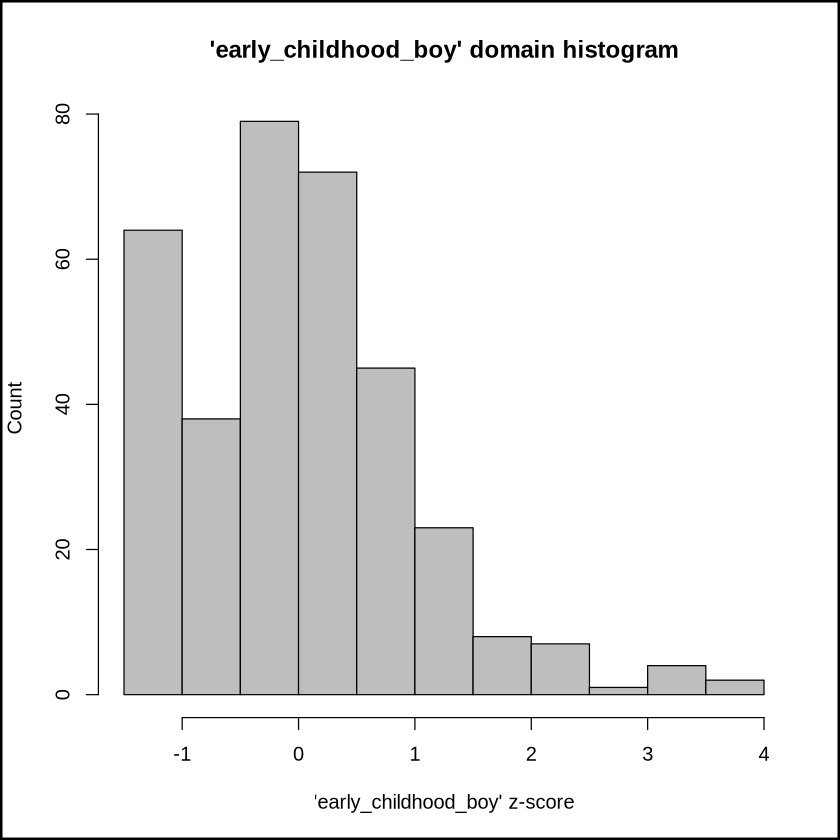

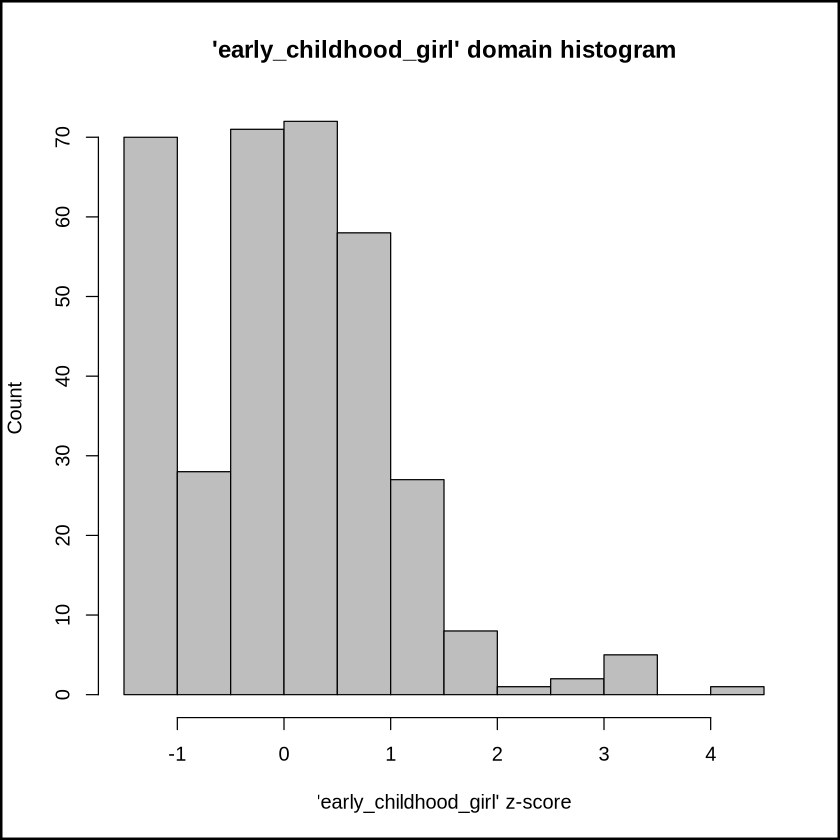

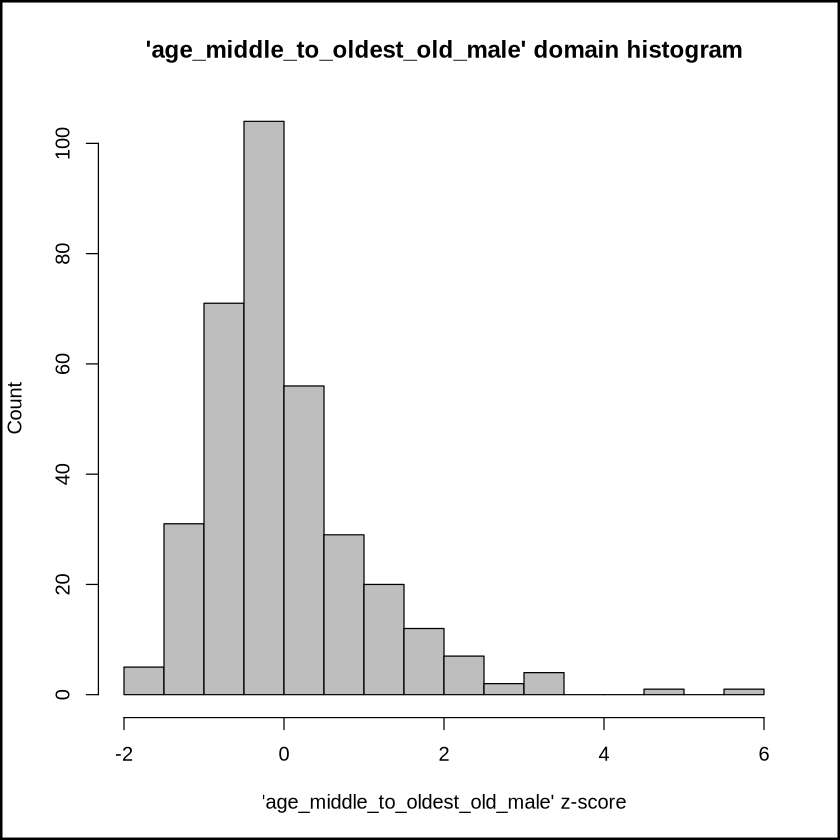

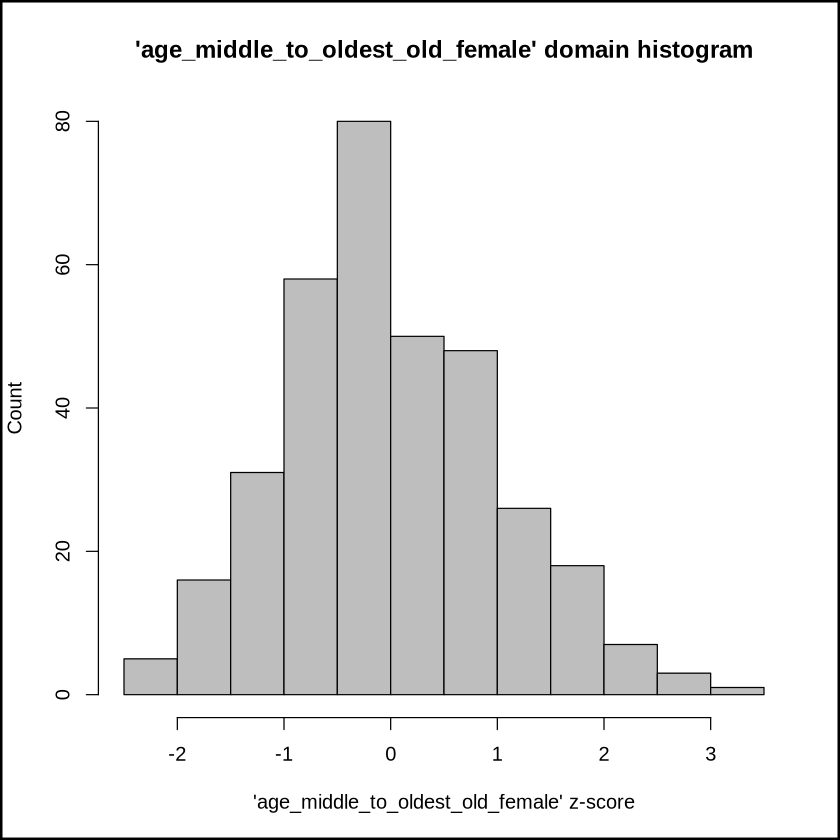

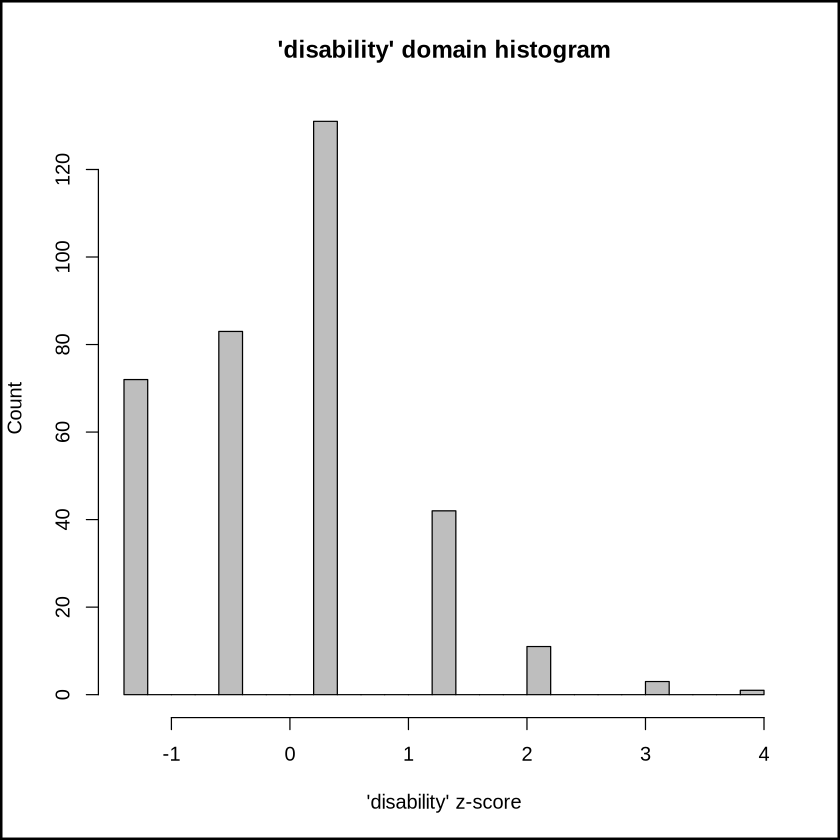

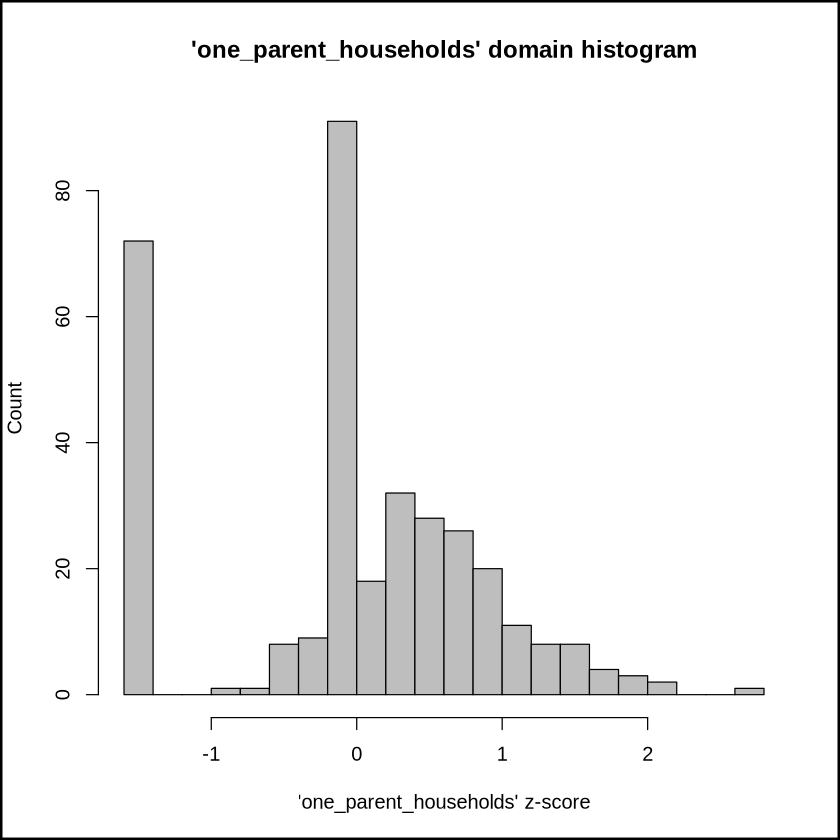

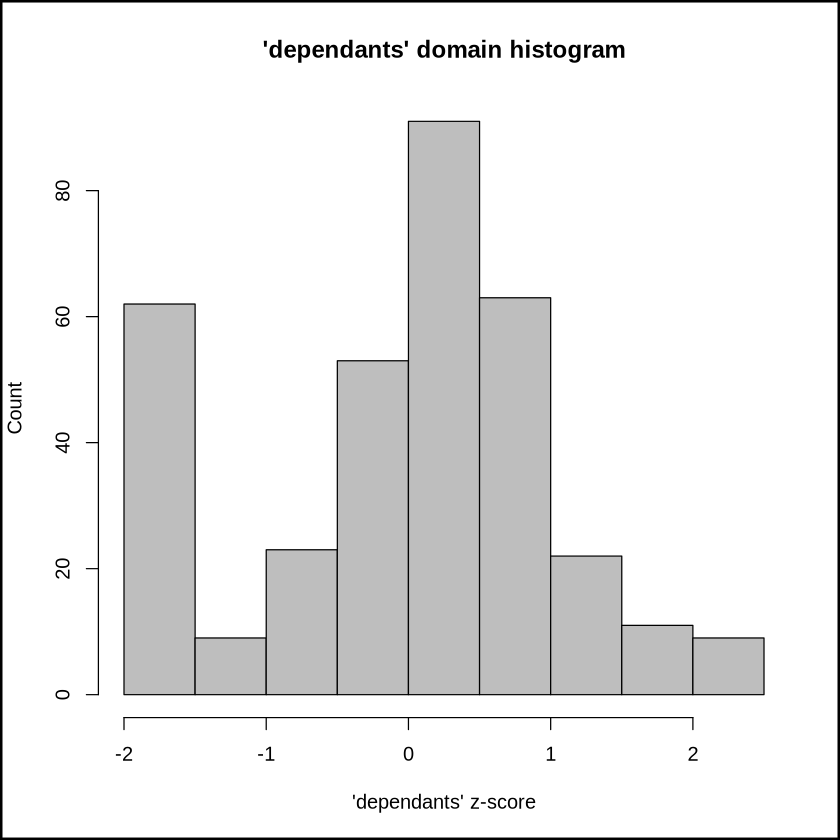

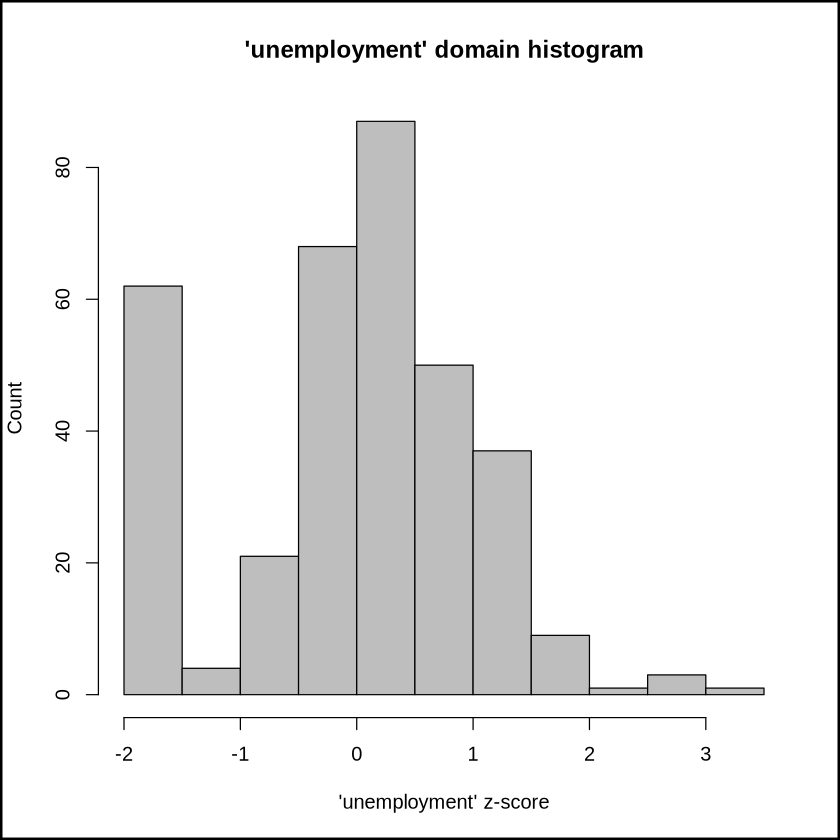

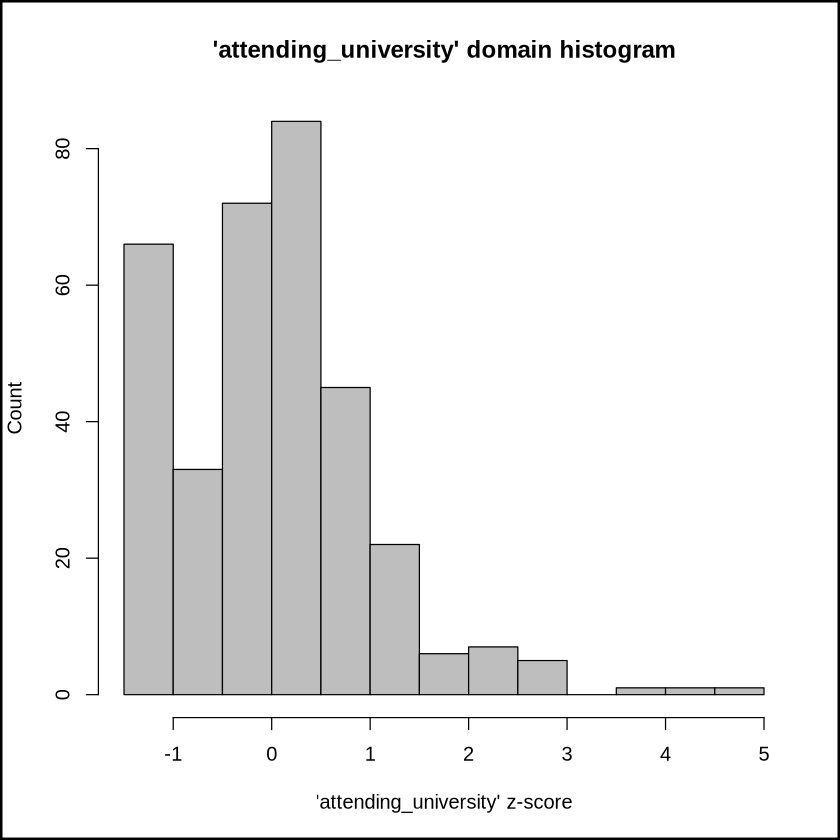

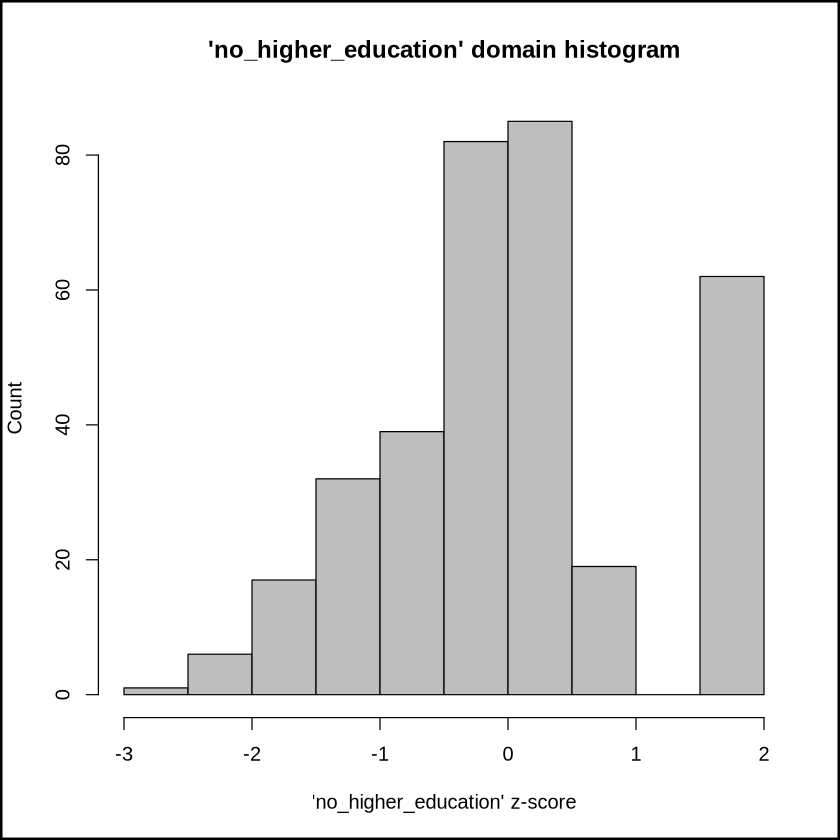

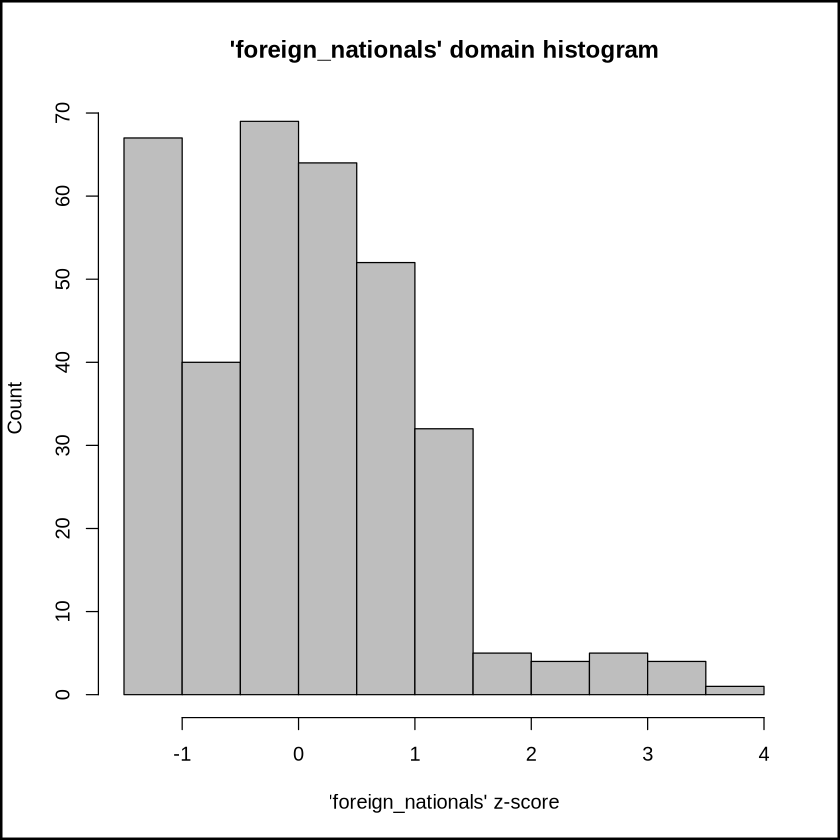

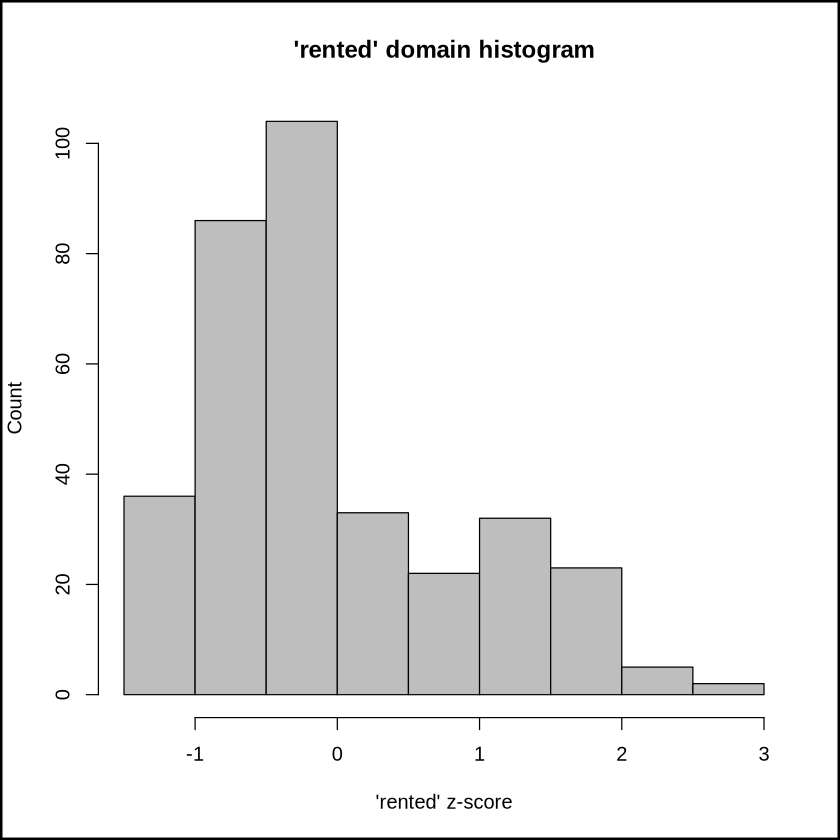

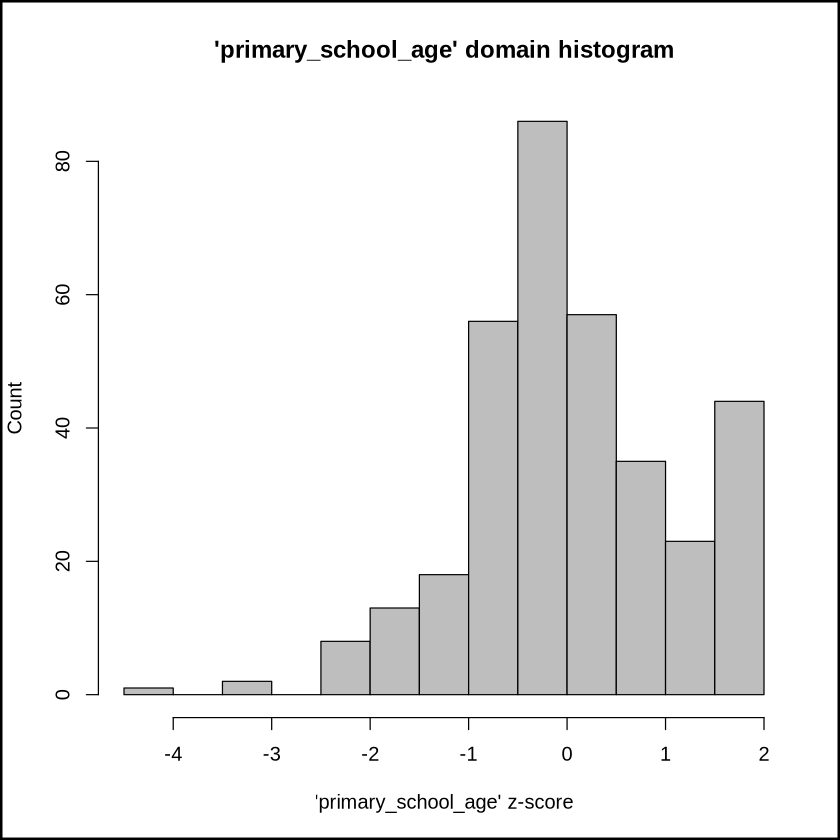

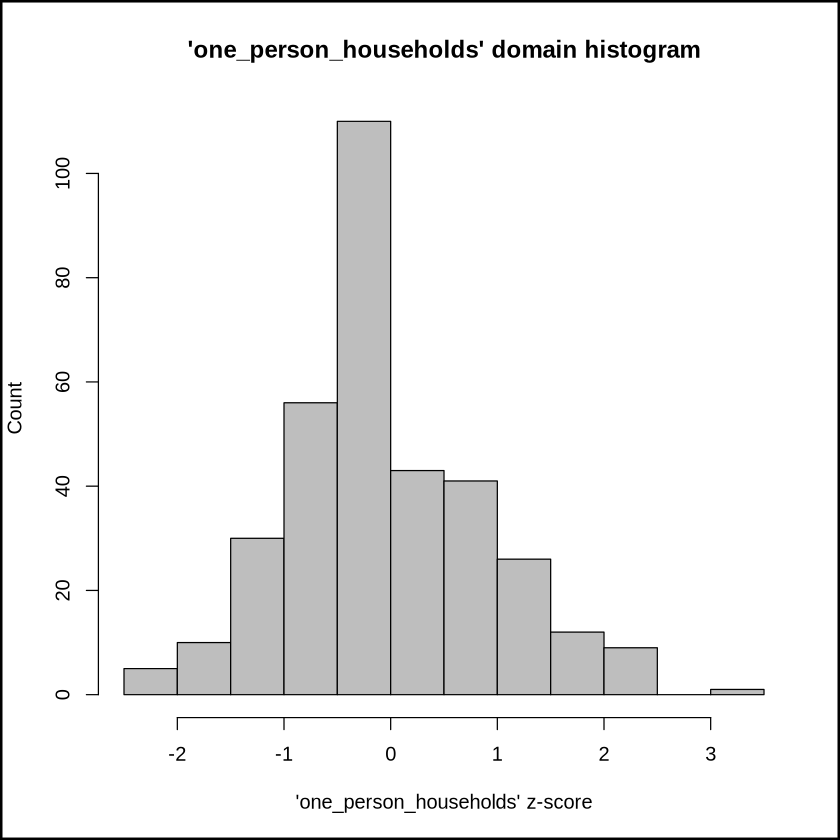

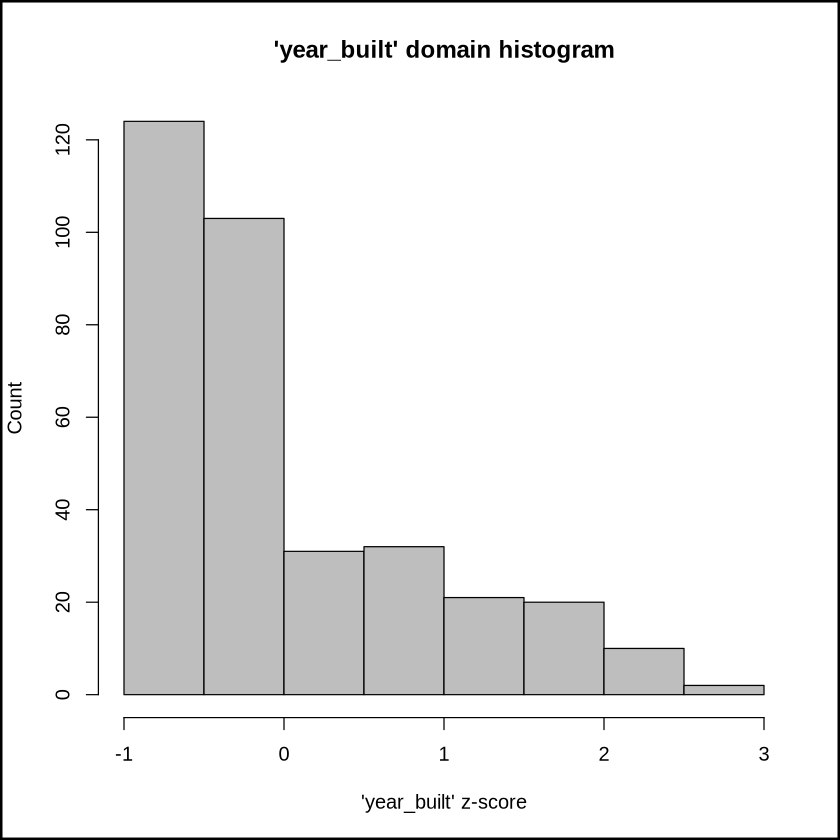

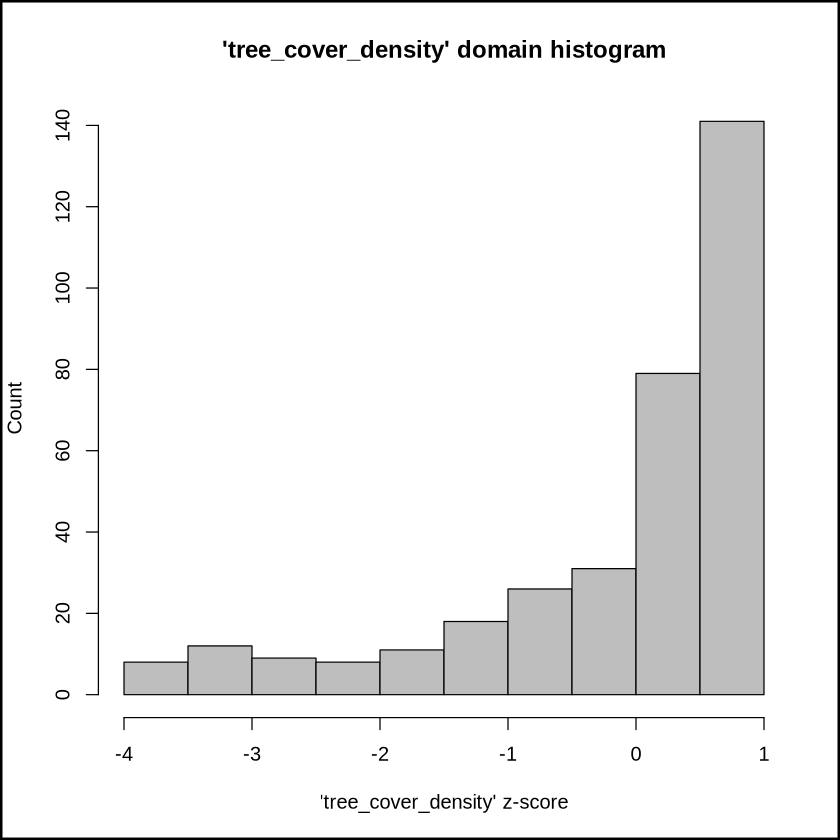

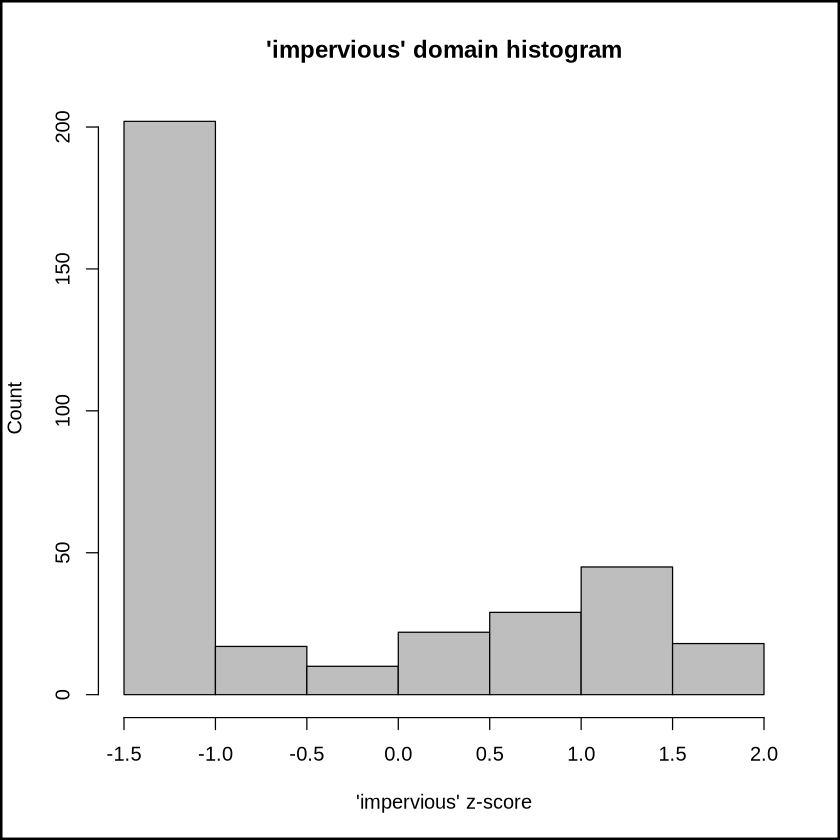

In [7]:
# Histogram visualisation of weighted indicators
index_start = GUID_length+1
index_end = ncol(indicator_data_weighted)
indicator_columns <- colnames(indicator_data_weighted)[index_start:index_end]
for( current_indicator_column in indicator_columns ) {
    indicator_filtered <- indicator_data_weighted[,current_indicator_column] 
    indicator_filtered[indicator_filtered == "NaN"] <- 0

    title <- paste("'", current_indicator_column, "' domain histogram", sep = "")
    x_label <- paste("'", current_indicator_column, "' z-score", sep = "")
    y_label <- paste("Count", sep = "")
    hist(indicator_filtered, breaks="FD", col="grey", labels = FALSE, main=title, xlab=x_label, ylab=y_label)
    box("figure", lwd = 4)
}

## Process social vulnerability scores

### Calculate domain scores

In [8]:
# Get the domains and their associated indicator ID
domain_indicators <- indicator_mapping %>% select('domain', 'indicator')

# Get a vector/array of the unique domain names
unique_domains <- unique(domain_indicators$domain)

# Initialise the domain score dataset with the GUID
domain_scores <- indicator_data_weighted %>% select(all_of(GUID))

# Loop through each domain
for (current_domain in unique_domains) {
    # Identify which indicators are used within this domain (current_domain)
    current_domain_info <- domain_indicators %>% filter(domain == current_domain)

    # Count the number of indicators in this domain
    domain_indicator_count <- length(current_domain_info$indicator)

    # Get a vector/array of the indicators used by this domain, and add the GUID column name
    current_domain_indicators <- current_domain_info$indicator
    current_domain_indicators <- (c(GUID, current_domain_indicators))

    # filter the dataset to only use the indicators in the domain
    current_domain_data <- indicator_data_weighted[current_domain_indicators]

    # Calculate the internal weight distribution for the indicators within this domain,
    # using an equal weight distribution across this domain
    internal_domain_weight <- 1.0 / domain_indicator_count

    # Internally weight the data for this domain
    current_domain_data_weighted <- current_domain_data %>% mutate_if(is.double, function(x) {x*internal_domain_weight})

    # Sum each data row to get the total score for the domain
    index_start = GUID_length+1
    index_end = domain_indicator_count+5
    current_domain_data_weighted[, current_domain] <- rowSums(current_domain_data_weighted[index_start:index_end], na.rm = TRUE)

    # Add the current domain score to the overall results
    domain_indicator_score <- current_domain_data_weighted %>% select(all_of(GUID), all_of(current_domain))
    domain_scores <- merge(domain_scores, domain_indicator_score, by=GUID)
}

# Print the first part of the domain z-scores, which are now collated into one table
head(domain_scores)

CCA CPRO CMUN CDIS CSEC age         health     income     info_access_use
1 17  26     1  1    1     0.01055472  1.2753218 -0.3313422 0.071438769    
2 17  26    10  1    1     0.26973904 -1.3865567 -1.1176156 1.619736710    
3 17  26   100  1    1    -0.41835186 -1.3865567 -1.1176156 1.619736710    
4 17  26   101  1    1    -0.72575121 -1.3865567 -1.1176156 1.619736710    
5 17  26   102  1    1     0.07217662  0.3880289  0.1439333 0.138756071    
6 17  26   102  1    2     0.47103144  0.3880289  0.2297142 0.004121467    
  local_knowledge tenure     social_network housing_characteristics
1  0.1446865      -0.5073936 0.36130070     -0.9481277             
2 -1.2514828       0.0000000 0.30303248      0.0000000             
3 -1.2514828       0.0000000 0.45418041      0.0000000             
4 -1.2514828       0.0000000 0.78526637      0.0000000             
5 -0.1091625      -0.7479582 0.41782180      1.2637707             
6  0.1446865      -0.9688721 0.06300444      0.7211874             
  physical_environment
1 -0.8560700          
2 -0.2328068          
3 -0.3822322          
4 -1.5116073          
5 -0.3792937          
6 -0.3696338

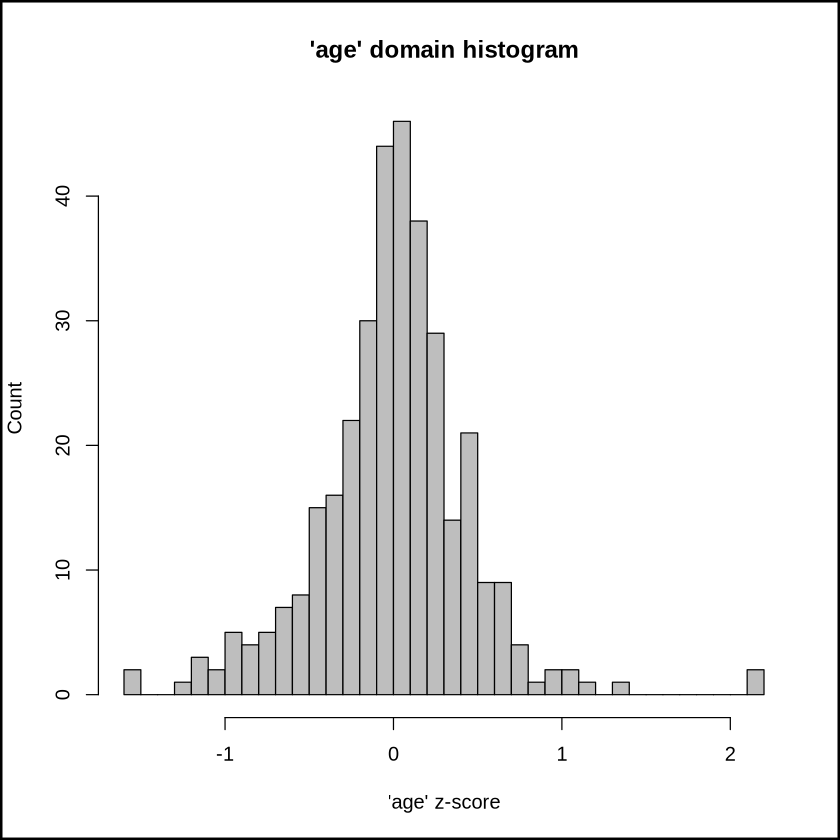

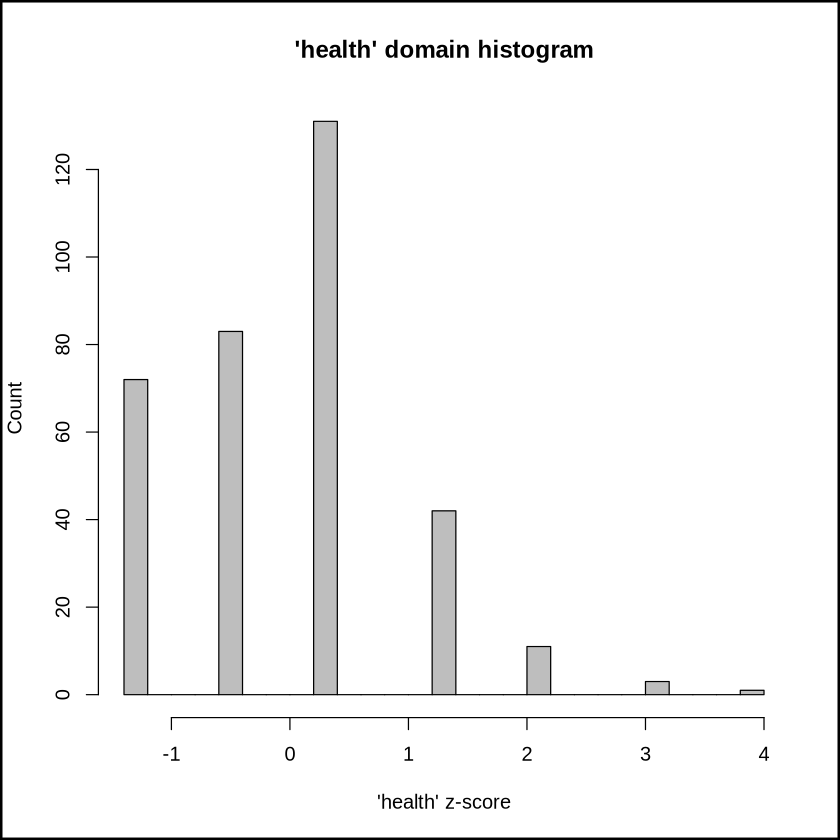

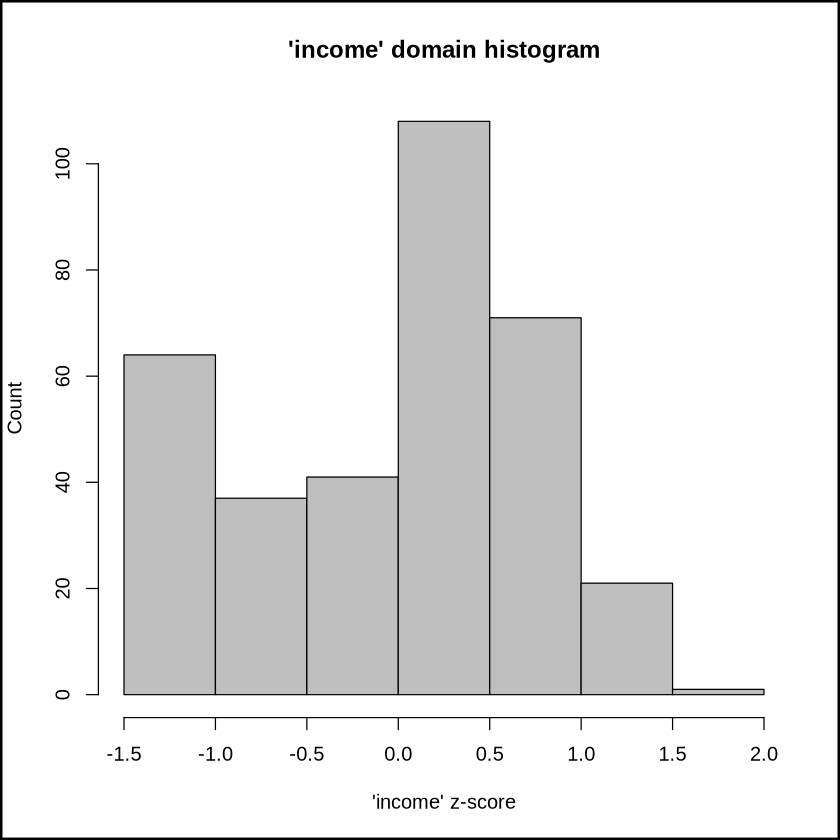

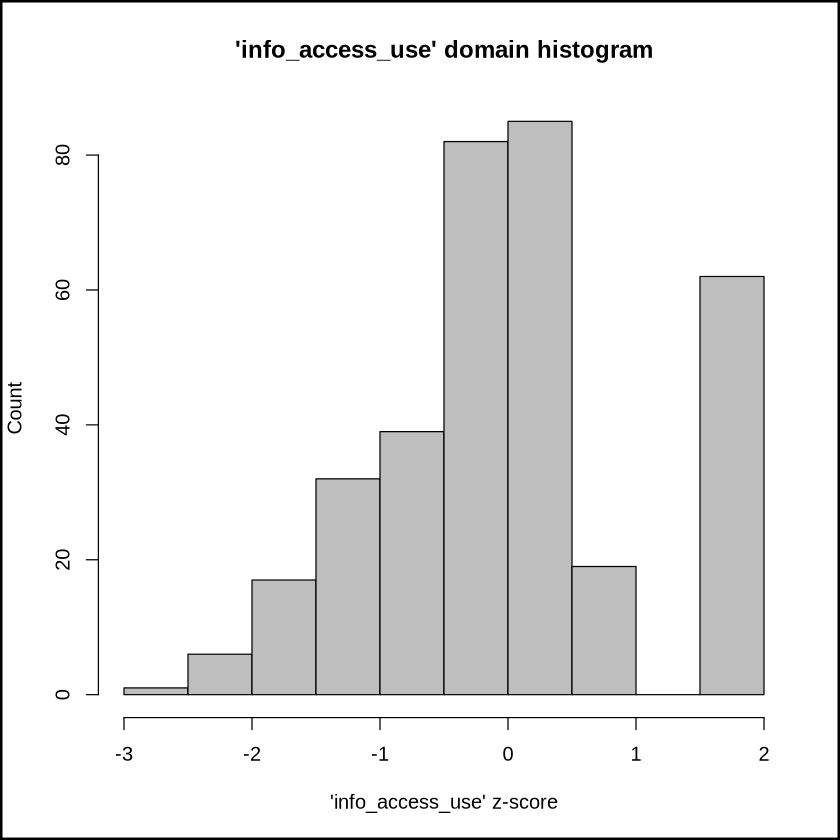

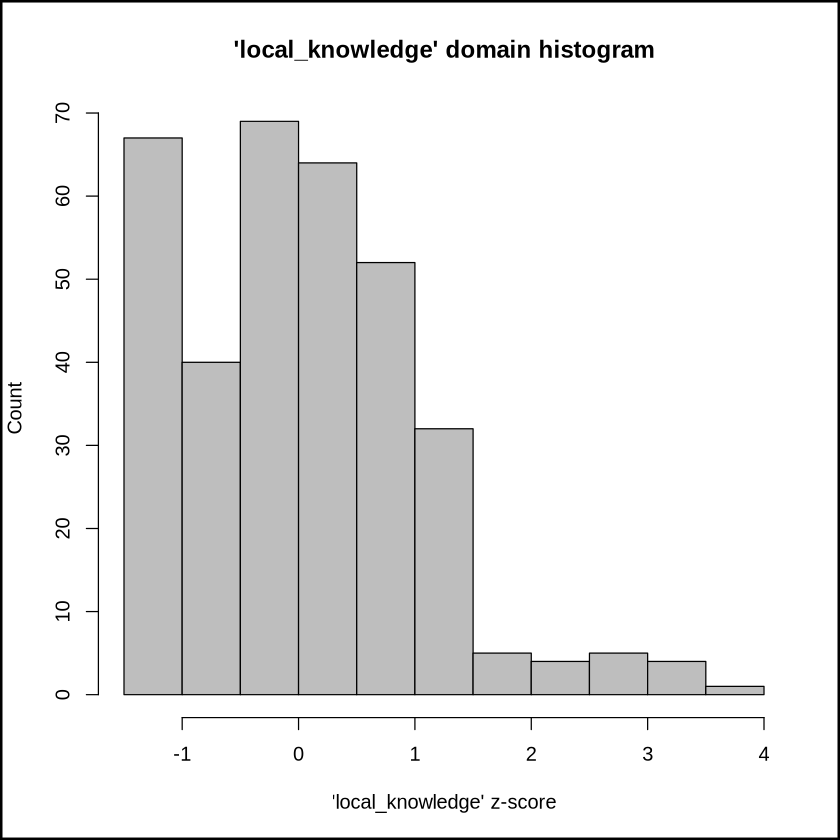

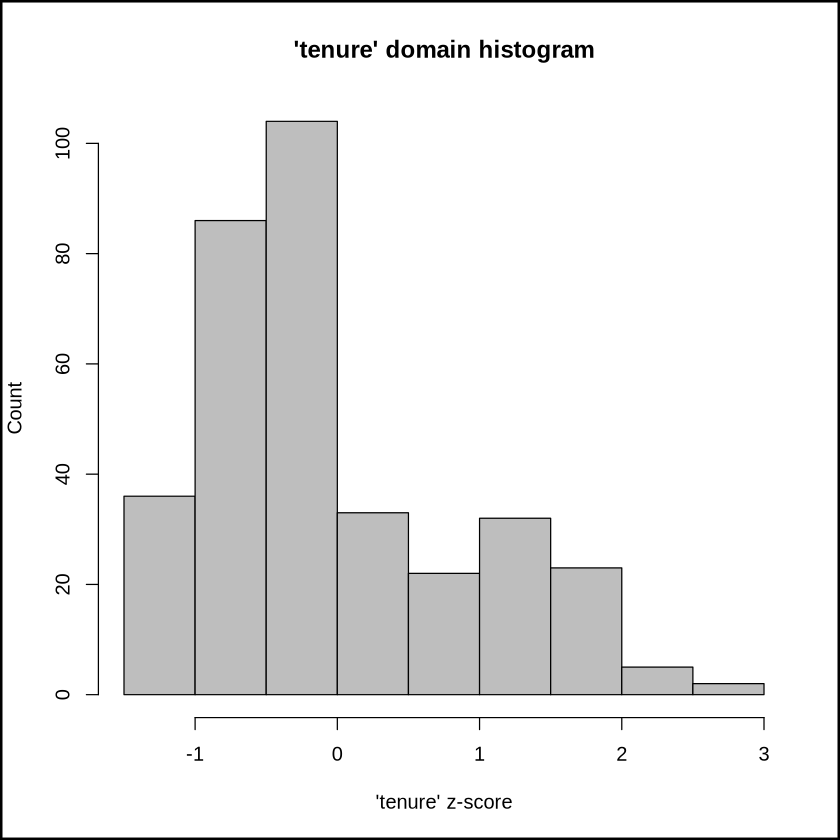

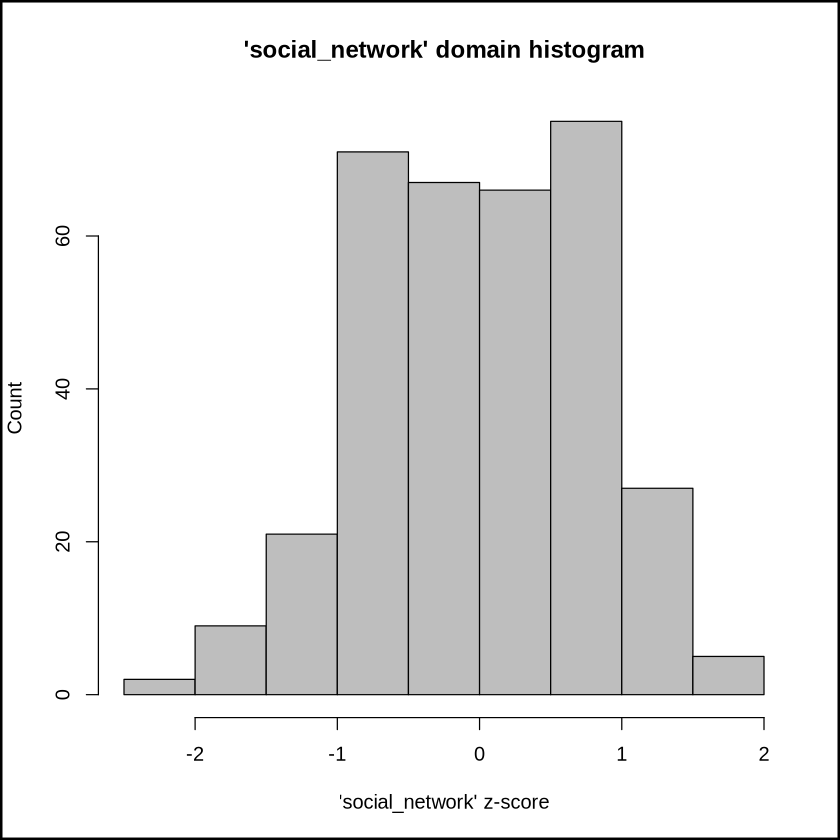

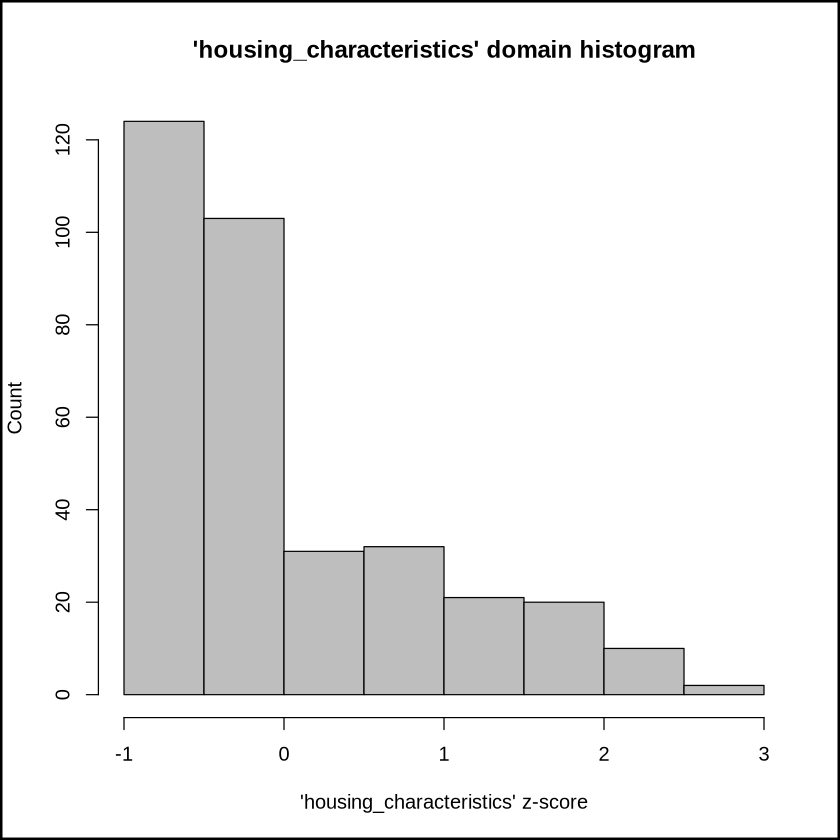

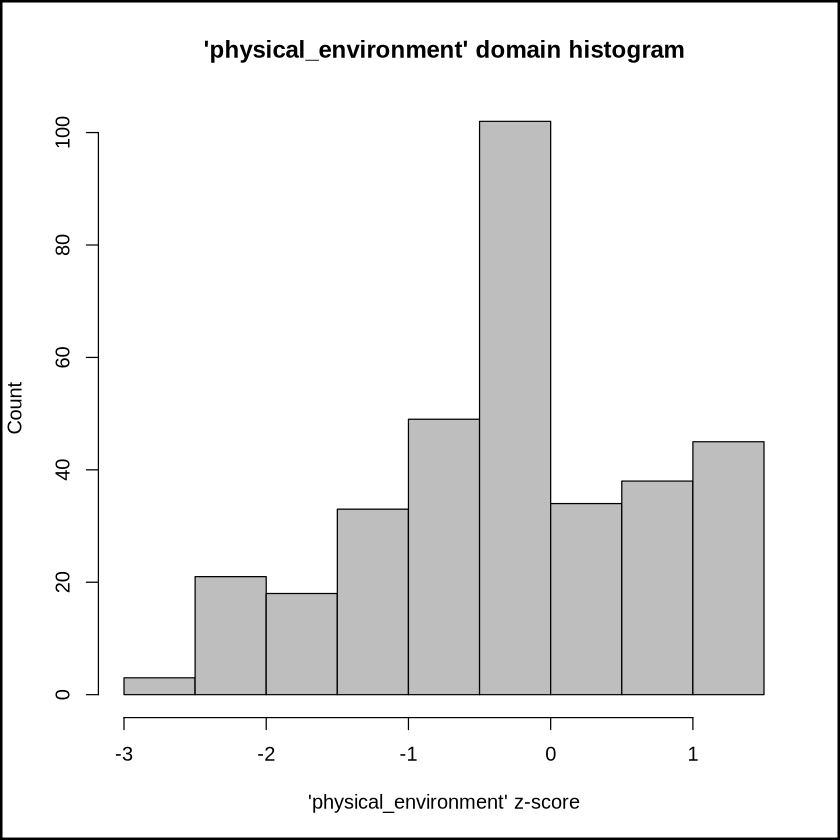

In [9]:
# Histogram visualisation of domain z-scores
for( current_domain in unique_domains ) {
    domain_scores_filtered <- domain_scores[,current_domain] 
    domain_scores_filtered[domain_scores_filtered == "NaN"] <- 0

    title <- paste("'", current_domain, "' domain histogram", sep = "")
    x_label <- paste("'", current_domain, "' z-score", sep = "")
    y_label <- paste("Count", sep = "")
    hist(domain_scores_filtered, breaks="FD", col="grey", labels=FALSE, main=title, xlab=x_label, ylab=y_label)
    box("figure", lwd = 4)
}

### Calculate dimension scores
Need to collate the domains into the dimensions

In [10]:
# Create a vector/array of the dimension names
dimensions <- c('sensitivity', 'prepare', 'respond', 'recover', 'adaptive_capacity', 'enhanced_exposure')

# Get the dimension and their associated indicator ID
dimension_indicators <- indicator_mapping %>% select(c('domain', all_of(dimensions)))
head(dimension_indicators)

# Initialise the dimensions score dataset with the GUID
dimension_scores <- indicator_data_weighted %>% select(all_of(GUID))

# loop through each of the dimensions and:
for (current_dimension in dimensions){
    # Identify which indicators are used within this dimension (current_dimension)
    # Then select the indicators marked with value 1, which means that the indicator is part of the dimension
    current_dimension_info <- dimension_indicators %>% select(c('domain', all_of(current_dimension)))
    current_dimension_info <- current_dimension_info %>% filter(dimension_indicators[, current_dimension] == 1)

    # Get a array/vector of the unique domains in this dimension
    current_dimension_domains <- unique(current_dimension_info$domain)

    # Count the number of domains in this dimension
    dimension_domain_count <- length(current_dimension_domains)

    # Filter the domain scores dataset to only use the domains in the dimension, and add the GUID column name
    current_dimension_data <- domain_scores %>% select(c(all_of(GUID), all_of(current_dimension_domains)))  

    # Sum each data row to get the total score for the dimension
    index_start = GUID_length+1
    index_end = dimension_domain_count+5
    current_dimension_data[, current_dimension] <- rowSums(current_dimension_data[index_start:index_end], na.rm = TRUE)

    # Add the current dimension score to the overall results
    dimension_indicator_score <- current_dimension_data %>% select(all_of(GUID), all_of(current_dimension))
    dimension_scores <- merge(dimension_scores, dimension_indicator_score, by=GUID)  
}

# generate z-scores with the scale function in order to standardise the dimension data
dimension_scores <- dimension_scores %>% mutate_if(is.double, scale)

# Print the first part of the dimension scores, which are now collated into one table
head(dimension_scores)

domain sensitivity prepare respond recover adaptive_capacity
1 age    1           0       0       0       0                
2 age    1           0       0       0       0                
3 age    1           0       0       0       0                
4 age    1           0       0       0       0                
5 health 1           0       0       0       0                
6 income 0           1       1       1       1                
  enhanced_exposure
1 0                
2 0                
3 0                
4 0                
5 0                
6 0

CCA CPRO CMUN CDIS CSEC sensitivity prepare    respond     recover  
1 17  26     1  1    1     1.1377171  -0.3378133  0.18457796 0.1073270
2 17  26    10  1    1    -0.9881374  -0.4065854 -0.33477437 0.8522391
3 17  26   100  1    1    -1.5969460  -0.4065854 -0.22140412 1.0122262
4 17  26   101  1    1    -1.8689267  -0.4065854  0.02693072 1.3626742
5 17  26   102  1    1     0.4071804  -0.3116725  0.44354790 0.7414772
6 17  26   102  1    2     0.7600790  -0.3203095  0.33117214 0.3141994
  adaptive_capacity enhanced_exposure
1 -0.15329655       -1.00827077      
2 -0.26183757        0.04893220      
3 -0.17316713       -0.05159845      
4  0.02106336       -0.81142134      
5 -0.09187444        0.80062025      
6 -0.30936550        0.44207919

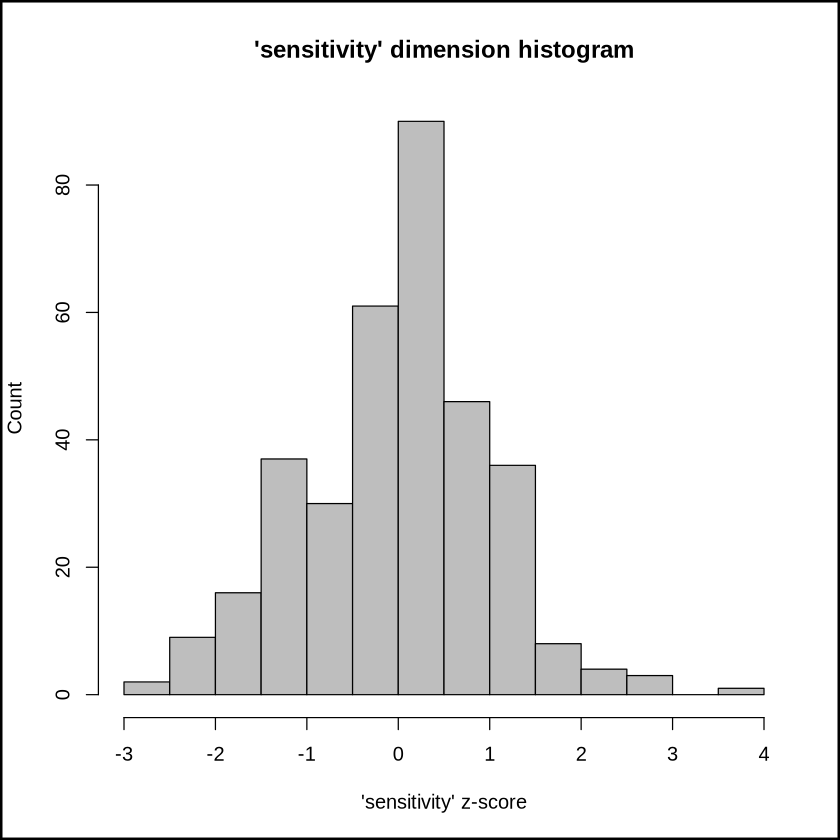

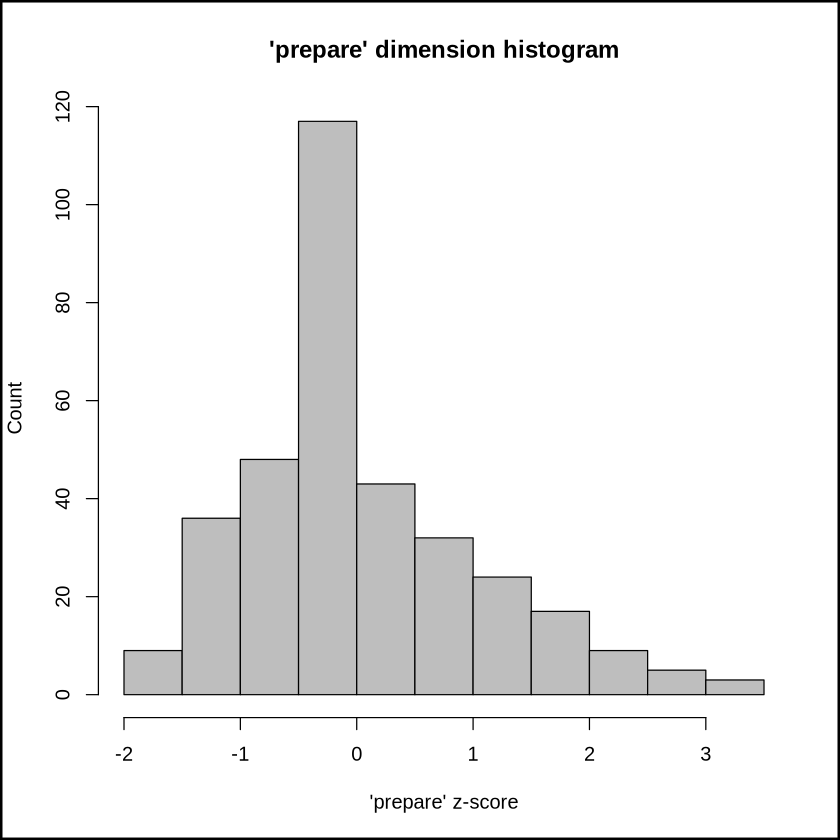

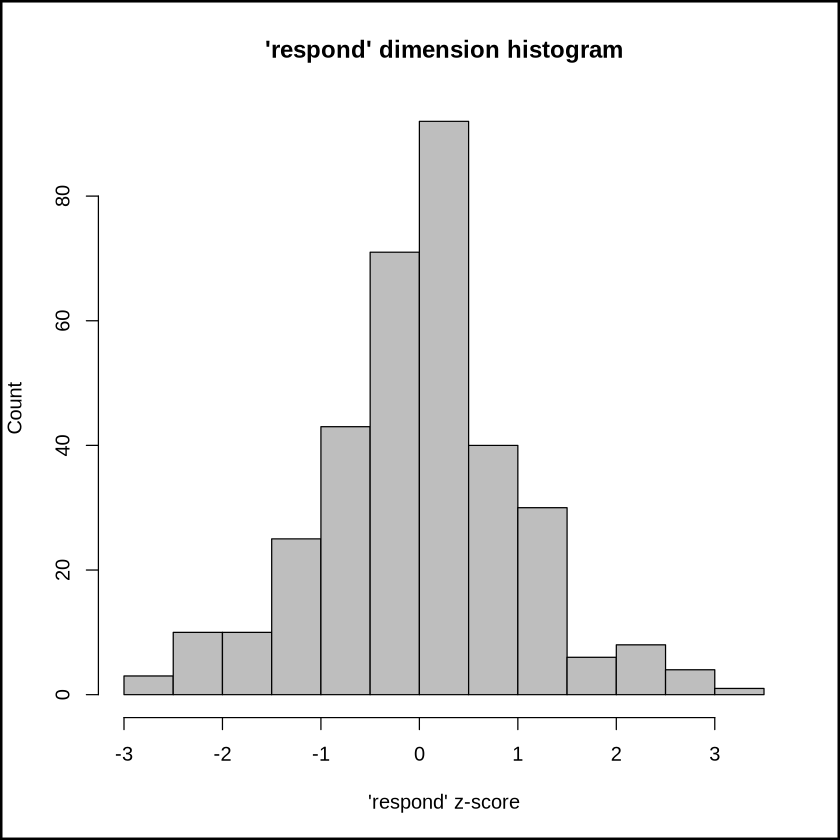

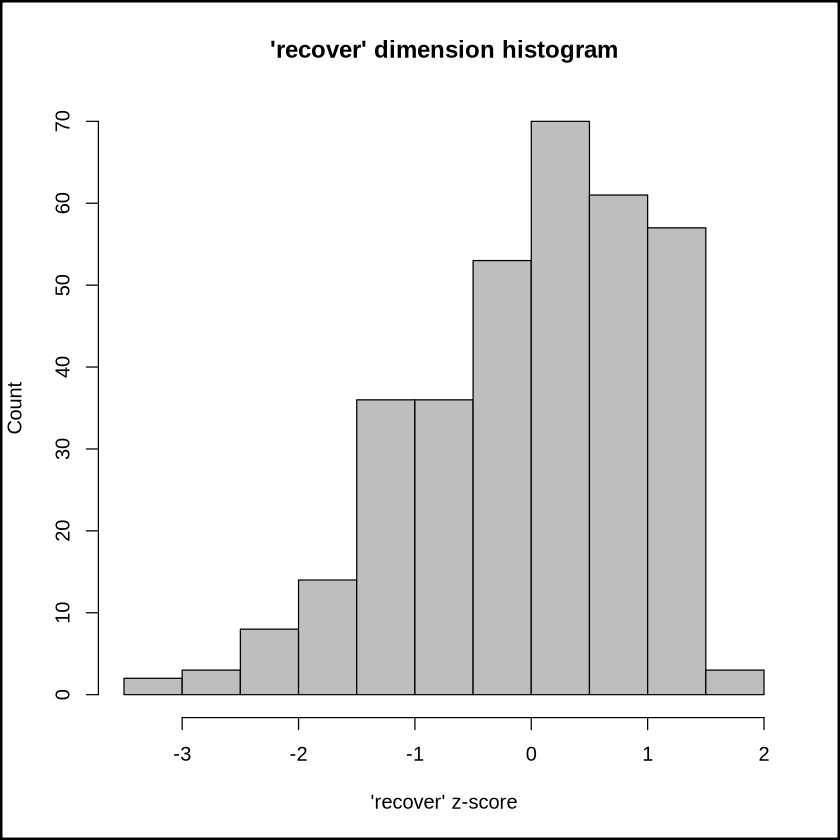

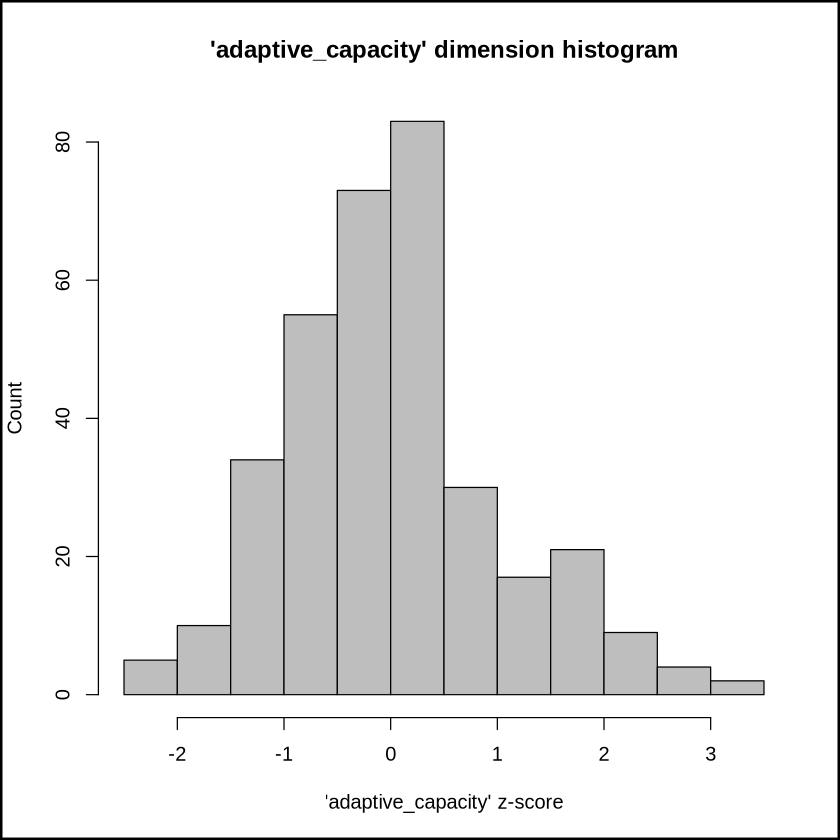

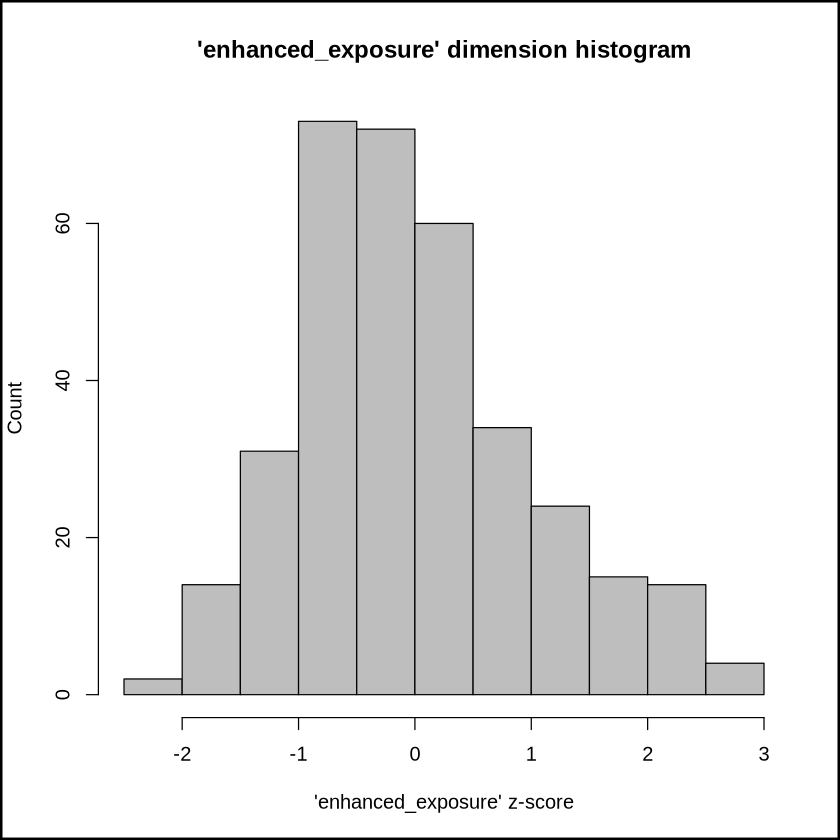

In [11]:
# Histogram visualisation of dimension z-scores
for( current_dimension in dimensions ){
    dimension_scores_filtered <- dimension_scores[,current_dimension] 
    dimension_scores_filtered[dimension_scores_filtered == "NaN"] <- 0
   
    title <- paste("'", current_dimension, "' dimension histogram", sep = "")
    x_label <- paste("'", current_dimension, "' z-score", sep = "")
    y_label <- paste("Count", sep = "")
    hist(dimension_scores_filtered, breaks="FD", col="grey", labels=FALSE, main=title, xlab=x_label, ylab=y_label)
    box("figure", lwd = 4)
}

## Calculate vulnerability score

In [12]:
# Initialise the vulnerability score dataset with the GUID
vulnerability_scores <- domain_scores %>% select(all_of(GUID))

#sum the domains to create a total overall score of vulnerability
index_start = GUID_length+1
index_end = ncol(domain_scores)
vulnerability_scores$social_vulnerability <- rowSums(domain_scores[index_start:index_end], na.rm = TRUE)

# generate z-scores with the scale function in order to standardise the vulnerability data
vulnerability_scores <- vulnerability_scores %>% mutate_if(is.double, scale)

# Print the first part of the vulnerability scores, which are now collated into one table
head(vulnerability_scores)

CCA CPRO CMUN CDIS CSEC social_vulnerability
1 17  26     1  1    1    -0.1413894          
2 17  26    10  1    1    -0.4444888          
3 17  26   100  1    1    -0.6491854          
4 17  26   101  1    1    -0.9789365          
5 17  26   102  1    1     0.4454417          
6 17  26   102  1    2     0.2948932

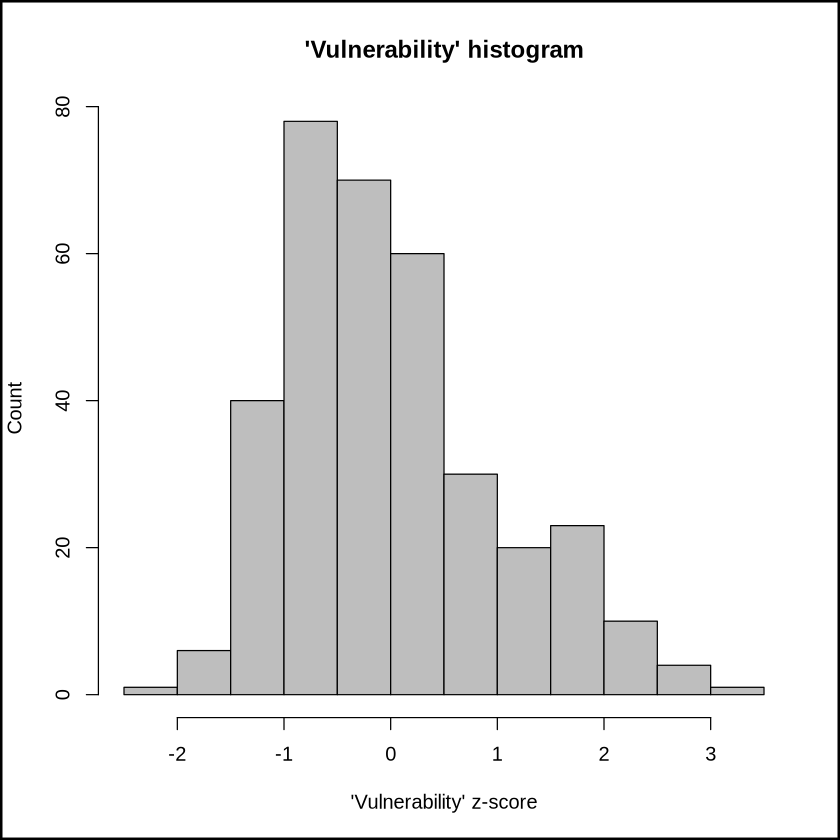

In [13]:
# Histogram visualisation of Vulnerability z-scores
title <- paste("'Vulnerability' histogram", sep = "")
x_label <- paste("'Vulnerability' z-score", sep = "")
y_label <- paste("Count", sep = "")
hist(vulnerability_scores$social_vulnerability, breaks="FD", col="grey", labels=FALSE, main=title, xlab=x_label, ylab=y_label)
box("figure", lwd = 4)

In [14]:
# Merge all the indicators, domains, dimensions, and total vulnerability into one dataset
output_dataset <- merge(indicator_data_weighted, domain_scores, by=GUID)
output_dataset <- merge(output_dataset, dimension_scores, by=GUID)
output_dataset <- merge(output_dataset, vulnerability_scores, by=GUID)

head(output_dataset)

CCA CPRO CMUN CDIS CSEC early_childhood_boy early_childhood_girl
1 17  26     1  1    1    -0.19258164         -0.1467916          
2 17  26    10  1    1    -0.36188692         -0.3284478          
3 17  26   100  1    1     0.01083739         -1.4002199          
4 17  26   101  1    1    -1.36078806         -1.4002199          
5 17  26   102  1    1     0.10257030         -0.4581527          
6 17  26   102  1    2     0.64987009          0.6302157          
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female disability ⋯
1  0.48180824                   -0.10021618                      1.2753218 ⋯
2  1.32081073                    0.44848018                     -1.3865567 ⋯
3  0.23798535                   -0.52201032                     -1.3865567 ⋯
4 -0.22155305                    0.07955613                     -1.3865567 ⋯
5  0.05129390                    0.59299501                      0.3880289 ⋯
6 -0.04065368                    0.64469364                      0.3880289 ⋯
  social_network housing_characteristics physical_environment sensitivity
1 0.36130070     -0.9481277              -0.8560700            1.1377171 
2 0.30303248      0.0000000              -0.2328068           -0.9881374 
3 0.45418041      0.0000000              -0.3822322           -1.5969460 
4 0.78526637      0.0000000              -1.5116073           -1.8689267 
5 0.41782180      1.2637707              -0.3792937            0.4071804 
6 0.06300444      0.7211874              -0.3696338            0.7600790 
  prepare    respond     recover   adaptive_capacity enhanced_exposure
1 -0.3378133  0.18457796 0.1073270 -0.15329655       -1.00827077      
2 -0.4065854 -0.33477437 0.8522391 -0.26183757        0.04893220      
3 -0.4065854 -0.22140412 1.0122262 -0.17316713       -0.05159845      
4 -0.4065854  0.02693072 1.3626742  0.02106336       -0.81142134      
5 -0.3116725  0.44354790 0.7414772 -0.09187444        0.80062025      
6 -0.3203095  0.33117214 0.3141994 -0.30936550        0.44207919      
  social_vulnerability
1 -0.1413894          
2 -0.4444888          
3 -0.6491854          
4 -0.9789365          
5  0.4454417          
6  0.2948932

## Correlations

In [15]:
# check the correlations
correlation <- cor(output_dataset %>% select(-c(all_of(GUID))), use="pairwise.complete.obs")
correlation

early_childhood_boy early_childhood_girl
early_childhood_boy              1.00000000          0.759540053        
early_childhood_girl             0.75954005          1.000000000        
age_middle_to_oldest_old_male   -0.44979947         -0.467072951        
age_middle_to_oldest_old_female -0.37263163         -0.365530974        
disability                       0.23018526          0.263640512        
one_parent_households            0.33038590          0.339863620        
dependants                       0.67057589          0.694355771        
unemployment                     0.35614054          0.360049506        
attending_university             0.23694332          0.295917170        
no_higher_education             -0.36085632         -0.396101779        
foreign_nationals                0.42604982          0.453075887        
rented                           0.19893150          0.200527443        
primary_school_age              -0.65679028         -0.690484814        
one_person_households           -0.22156559         -0.267393210        
year_built                       0.10505797          0.091155756        
tree_cover_density               0.38502113          0.414558106        
impervious                       0.20875349          0.239541111        
age                              0.51441045          0.508826242        
health                           0.23018526          0.263640512        
income                           0.53809505          0.570891186        
info_access_use                 -0.36085632         -0.396101779        
local_knowledge                  0.42604982          0.453075887        
tenure                           0.19893150          0.200527443        
social_network                  -0.54832658         -0.596400846        
housing_characteristics          0.10505797          0.091155756        
physical_environment             0.35289264          0.388099588        
sensitivity                      0.41094687          0.438297216        
prepare                          0.34499285          0.354235222        
respond                          0.02040882          0.003914884        
recover                         -0.42216457         -0.474047225        
adaptive_capacity                0.12155807          0.109504790        
enhanced_exposure                0.29297386          0.307359416        
social_vulnerability             0.33018312          0.339651432        
                                age_middle_to_oldest_old_male
early_childhood_boy             -0.44979947                  
early_childhood_girl            -0.46707295                  
age_middle_to_oldest_old_male    1.00000000                  
age_middle_to_oldest_old_female  0.55481678                  
disability                      -0.29036166                  
one_parent_households           -0.45598571                  
dependants                      -0.62497380                  
unemployment                    -0.34357715                  
attending_university            -0.42706479                  
no_higher_education              0.43854968                  
foreign_nationals               -0.33707442                  
rented                          -0.26872461                  
primary_school_age               0.55898237                  
one_person_households            0.35142193                  
year_built                      -0.09769664                  
tree_cover_density              -0.31956017                  
impervious                      -0.30448896                  
age                              0.35018899                  
health                          -0.29036166                  
income                          -0.62267021                  
info_access_use                  0.43854968                  
local_knowledge                 -0.33707442                  
tenure                          -0.26872461                  
social_network                   0.56092053                  


## Add geometry

In [16]:
# add st_drop_geometry
output_dataset_geom <- merge(output_dataset, oa, by.x=GUID, by.y=GUID, all.x = TRUE)
head(output_dataset_geom)

CCA CPRO CMUN CDIS CSEC early_childhood_boy early_childhood_girl
1 17  26     1  1    1    -0.19258164         -0.1467916          
2 17  26    10  1    1    -0.36188692         -0.3284478          
3 17  26   100  1    1     0.01083739         -1.4002199          
4 17  26   101  1    1    -1.36078806         -1.4002199          
5 17  26   102  1    1     0.10257030         -0.4581527          
6 17  26   102  1    2     0.64987009          0.6302157          
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female disability ⋯
1  0.48180824                   -0.10021618                      1.2753218 ⋯
2  1.32081073                    0.44848018                     -1.3865567 ⋯
3  0.23798535                   -0.52201032                     -1.3865567 ⋯
4 -0.22155305                    0.07955613                     -1.3865567 ⋯
5  0.05129390                    0.59299501                      0.3880289 ⋯
6 -0.04065368                    0.64469364                      0.3880289 ⋯
  housing_characteristics physical_environment sensitivity prepare   
1 -0.9481277              -0.8560700            1.1377171  -0.3378133
2  0.0000000              -0.2328068           -0.9881374  -0.4065854
3  0.0000000              -0.3822322           -1.5969460  -0.4065854
4  0.0000000              -1.5116073           -1.8689267  -0.4065854
5  1.2637707              -0.3792937            0.4071804  -0.3116725
6  0.7211874              -0.3696338            0.7600790  -0.3203095
  respond     recover   adaptive_capacity enhanced_exposure
1  0.18457796 0.1073270 -0.15329655       -1.00827077      
2 -0.33477437 0.8522391 -0.26183757        0.04893220      
3 -0.22140412 1.0122262 -0.17316713       -0.05159845      
4  0.02693072 1.3626742  0.02106336       -0.81142134      
5  0.44354790 0.7414772 -0.09187444        0.80062025      
6  0.33117214 0.3141994 -0.30936550        0.44207919      
  social_vulnerability geometry                      
1 -0.1413894           MULTIPOLYGON (((526123.5 47...
2 -0.4444888           MULTIPOLYGON (((528744.7 46...
3 -0.6491854           MULTIPOLYGON (((575382.6 46...
4 -0.9789365           MULTIPOLYGON (((540334.4 46...
5  0.4454417           MULTIPOLYGON (((521986.4 46...
6  0.2948932           MULTIPOLYGON (((519949.8 47...

# Export

In [17]:
# CSV
write.csv(output_dataset, file.path(output_dir, "social_vulnerability_index_logrono_2021.csv"), row.names = FALSE)

# GeoJSON
st_write(output_dataset_geom, file.path(output_dir, "social_vulnerability_index_logrono_2021.geojson"), delete_dsn=TRUE)

# Shapefile
# Need to manually rename these fields, otherwise we get a shapefile creation error
names(output_dataset_geom)[names(output_dataset_geom) == 'early_childhood_boy'] <- 'erly_cld_b'
names(output_dataset_geom)[names(output_dataset_geom) == 'early_childhood_girl'] <- 'erly_cld_g'
names(output_dataset_geom)[names(output_dataset_geom) == 'age_middle_to_oldest_old_male'] <- 'age_old_m'
names(output_dataset_geom)[names(output_dataset_geom) == 'age_middle_to_oldest_old_female'] <- 'age_old_f'
st_write(output_dataset_geom, file.path(output_dir, "social_vulnerability_index_logrono_2021.shp"), append = FALSE)

Deleting source `../../3_outputs/Spain/Logrono/2021/social_vulnerability_index_logrono_2021.geojson' using driver `GeoJSON'
Writing layer `social_vulnerability_index_logrono_2021' to data source 
  `../../3_outputs/Spain/Logrono/2021/social_vulnerability_index_logrono_2021.geojson' using driver `GeoJSON'
Writing 343 features with 38 fields and geometry type Multi Polygon.


Warning message in abbreviate_shapefile_names(obj):
“Field names abbreviated for ESRI Shapefile driver”


Deleting layer `social_vulnerability_index_logrono_2021' using driver `ESRI Shapefile'
Writing layer `social_vulnerability_index_logrono_2021' to data source 
  `../../3_outputs/Spain/Logrono/2021/social_vulnerability_index_logrono_2021.shp' using driver `ESRI Shapefile'
Writing 343 features with 38 fields and geometry type Multi Polygon.


**END**